In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

In [4]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [5]:
import optax

In [6]:
from QCBM import QCBM, KLDivergence, MMD

## Mixture of Gaussains

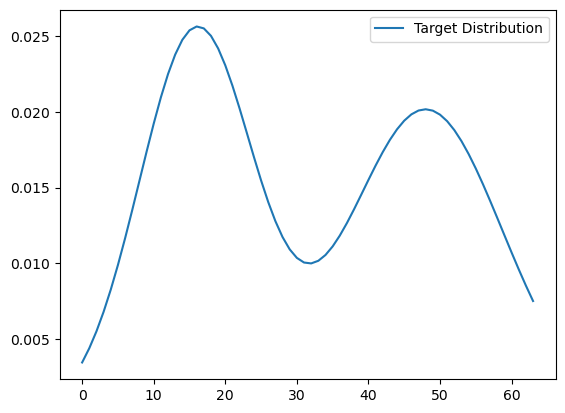

In [7]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(1 / 4) * x_max, (3 / 4) * x_max]
sigmas = [x_max / 8, x_max/6]
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label="Target Distribution")
plt.legend()
plt.show()

## Strongly Entagled Layers - How many Layers should we use

In [ ]:
def QCBM_N_layers_run(n_layers = 4):
    print(f'-- {n_layers} Strongly Entangled Layers --')
    dev = qml.device("default.qubit", wires=n_qubits)

    wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = np.random.random(size=wshape)

    @qml.qnode(dev)
    def circuit(weights):
        qml.StronglyEntanglingLayers(
            weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
        )
        return qml.probs()


    jit_circuit = jax.jit(circuit)

    qml.draw_mpl(circuit, level="device")(weights)
    plt.savefig(f'Ansatz/StronglyEntanglingLayers/{n_layers}_StronglyEntanglingLayers_ansatz')
    plt.show()

    bandwidth = jnp.array([0.25, 60])
    space = jnp.arange(2**n_qubits)

    mmd = MMD(bandwidth, space)
    qcbm = QCBM(jit_circuit, mmd, data)

    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(weights)

    history = []
    divs = []
    n_iterations = 200
    #n_iterations = int(200 / n_layers)


    for i in range(n_iterations):
        (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
        updates, opt_state = opt.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
        kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
        # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

        if i % 10 == 0:
            print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

        history.append(loss_val)
        divs.append(kl_div)
    
    # Plot the loss history
    plt.figure(figsize=(8, 6))
    plt.plot(history, label="Loss History", color='blue')
    plt.xlabel("Iterations")
    plt.ylabel("Loss Value")
    plt.title(f"StronglyEntangledLayers {n_layers} Layers Loss History")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f"Results/StronglyEntangled/n_Layers/StronglyEntangledLayers_{n_layers}_Loss_History_logscale.png")
    plt.show()

    # Plot the KL divergence history
    plt.figure(figsize=(8, 6))
    plt.plot(divs, label="KL Divergence", color='orange')
    plt.xlabel("Iterations")
    plt.ylabel("KL Divergence")
    plt.title(f"StronglyEntangledLayers {n_layers} Layers KL Divergence History")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f"Results/StronglyEntangled/n_Layers/StronglyEntangledLayers_{n_layers}_KL_Div_History_logscale.png")
    plt.show()


    qcbm_probs = qcbm.circ(weights)

    # plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
    plt.plot(range(x_max), data, label="Target Distribution")
    plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

    plt.xlabel("Samples")
    plt.ylabel("Prob. Distribution")

    plt.title(f'Resutls from {n_layers} Strongly Entangled Layers Ansatz for QCBM')

    plt.legend()
    plt.show()

    return history, divs

-- 1 Strongly Entangled Layers --


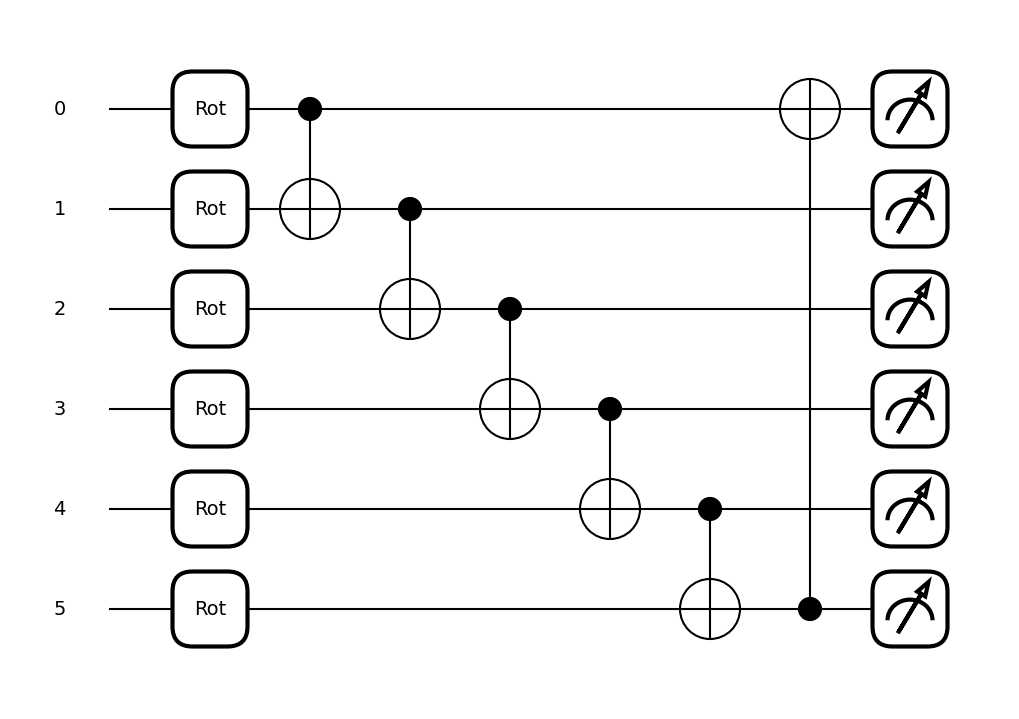

Step: 0 Loss: 0.2296 KL-div: 10.3230
Step: 10 Loss: 0.0079 KL-div: 0.4480
Step: 20 Loss: 0.0026 KL-div: 0.1390
Step: 30 Loss: 0.0050 KL-div: 0.2364
Step: 40 Loss: 0.0016 KL-div: 0.0887
Step: 50 Loss: 0.0006 KL-div: 0.0399
Step: 60 Loss: 0.0004 KL-div: 0.0284
Step: 70 Loss: 0.0003 KL-div: 0.0263
Step: 80 Loss: 0.0003 KL-div: 0.0255
Step: 90 Loss: 0.0003 KL-div: 0.0243
Step: 100 Loss: 0.0003 KL-div: 0.0236
Step: 110 Loss: 0.0003 KL-div: 0.0233
Step: 120 Loss: 0.0003 KL-div: 0.0233
Step: 130 Loss: 0.0003 KL-div: 0.0234
Step: 140 Loss: 0.0003 KL-div: 0.0234
Step: 150 Loss: 0.0003 KL-div: 0.0235
Step: 160 Loss: 0.0003 KL-div: 0.0235
Step: 170 Loss: 0.0003 KL-div: 0.0234
Step: 180 Loss: 0.0003 KL-div: 0.0234
Step: 190 Loss: 0.0003 KL-div: 0.0234


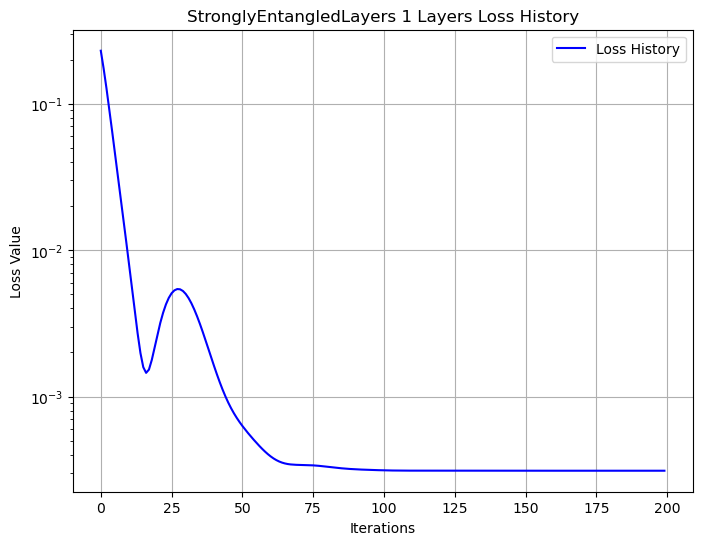

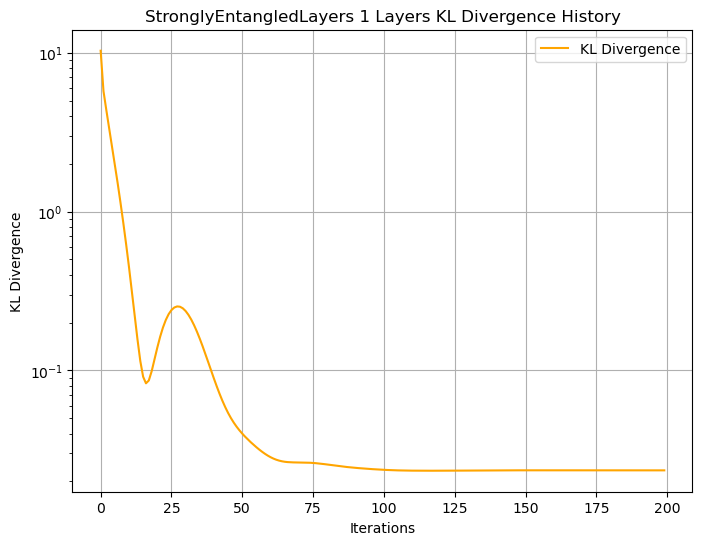

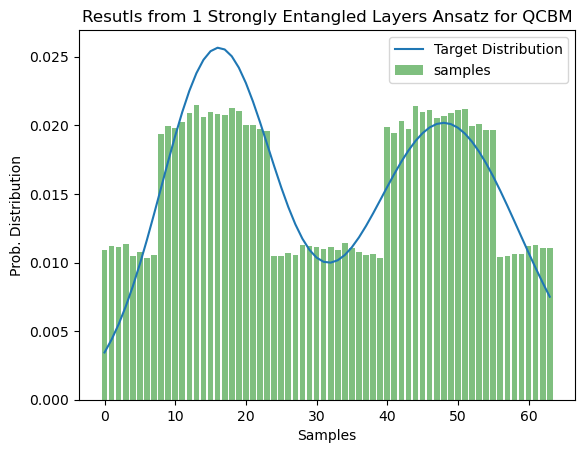

-- 2 Strongly Entangled Layers --


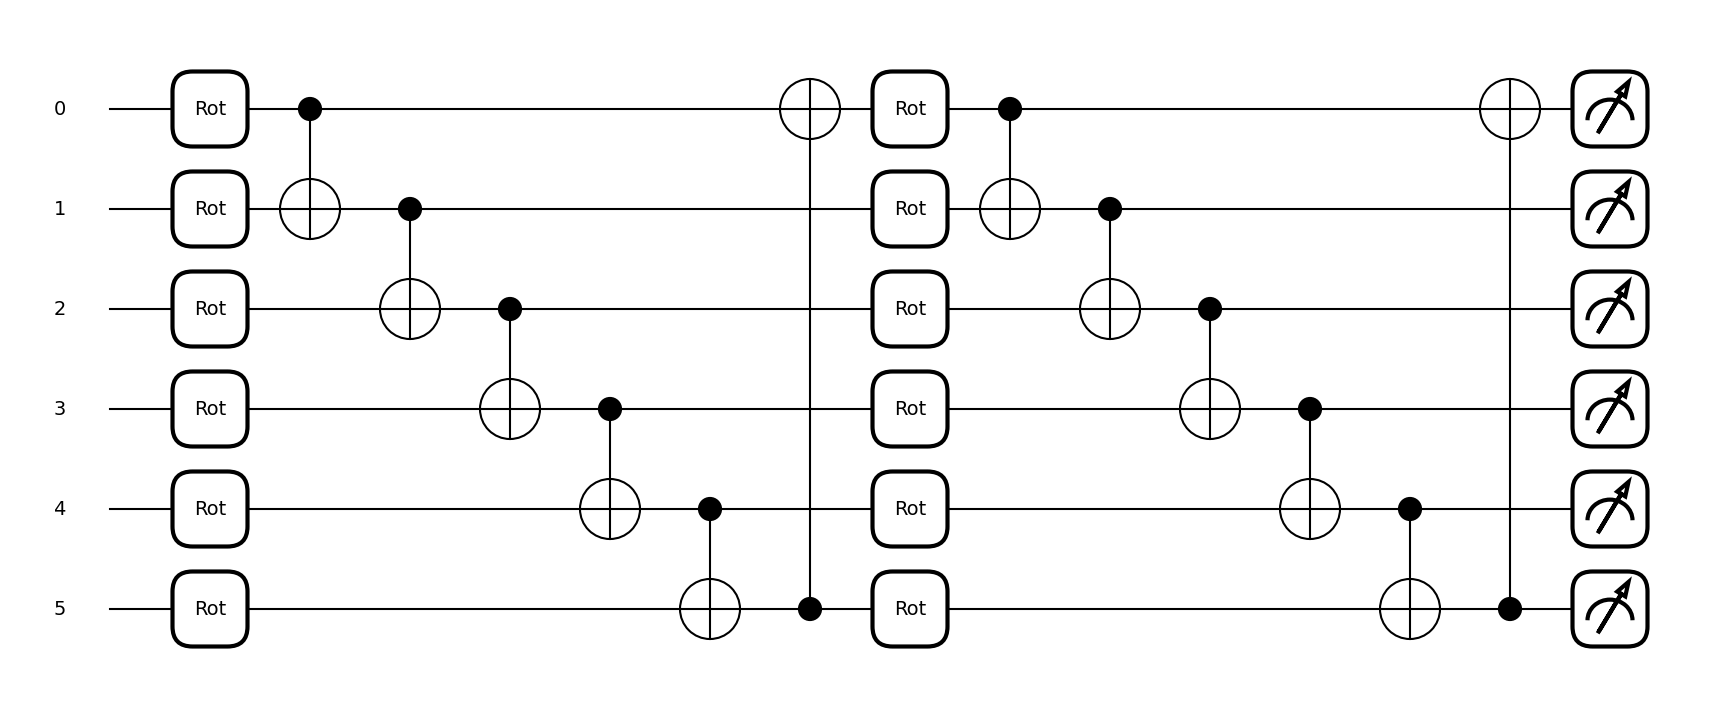

Step: 0 Loss: 0.0486 KL-div: 1.4983
Step: 10 Loss: 0.0042 KL-div: 0.4629
Step: 20 Loss: 0.0037 KL-div: 0.3259
Step: 30 Loss: 0.0019 KL-div: 0.1544
Step: 40 Loss: 0.0009 KL-div: 0.0654
Step: 50 Loss: 0.0006 KL-div: 0.0376
Step: 60 Loss: 0.0004 KL-div: 0.0302
Step: 70 Loss: 0.0003 KL-div: 0.0194
Step: 80 Loss: 0.0002 KL-div: 0.0152
Step: 90 Loss: 0.0002 KL-div: 0.0142
Step: 100 Loss: 0.0002 KL-div: 0.0141
Step: 110 Loss: 0.0002 KL-div: 0.0139
Step: 120 Loss: 0.0002 KL-div: 0.0138
Step: 130 Loss: 0.0002 KL-div: 0.0138
Step: 140 Loss: 0.0002 KL-div: 0.0137
Step: 150 Loss: 0.0002 KL-div: 0.0137
Step: 160 Loss: 0.0002 KL-div: 0.0137
Step: 170 Loss: 0.0002 KL-div: 0.0137
Step: 180 Loss: 0.0002 KL-div: 0.0136
Step: 190 Loss: 0.0002 KL-div: 0.0136


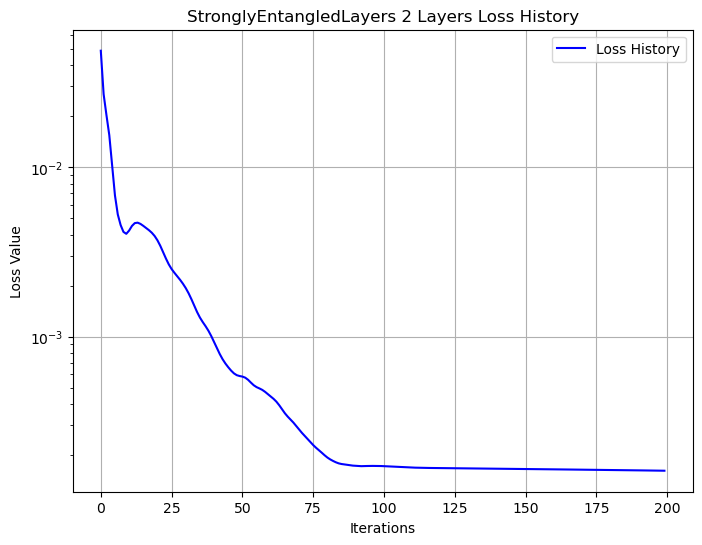

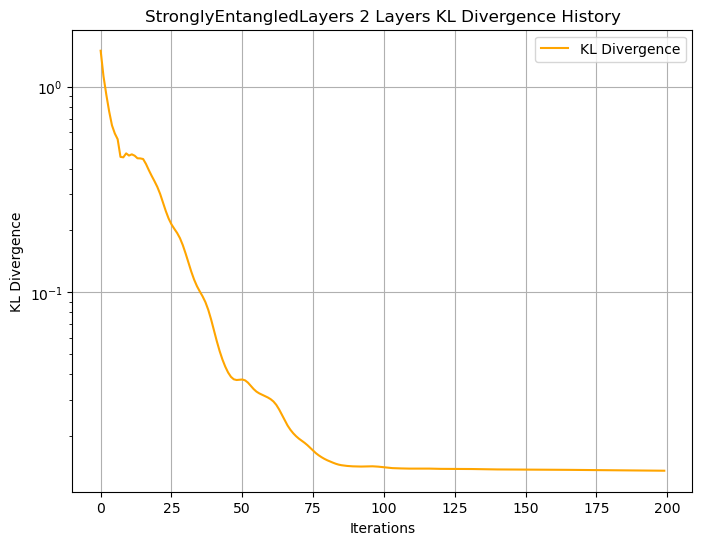

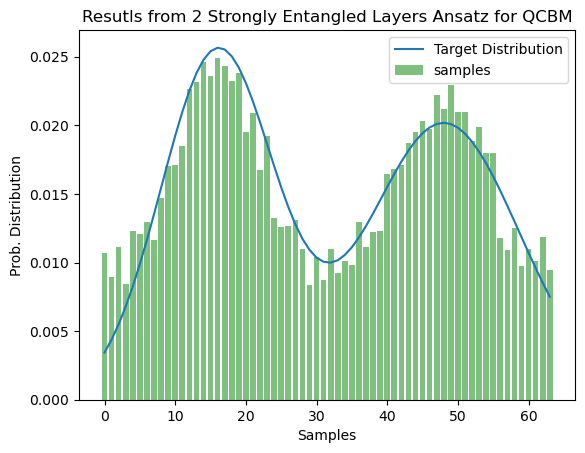

-- 3 Strongly Entangled Layers --


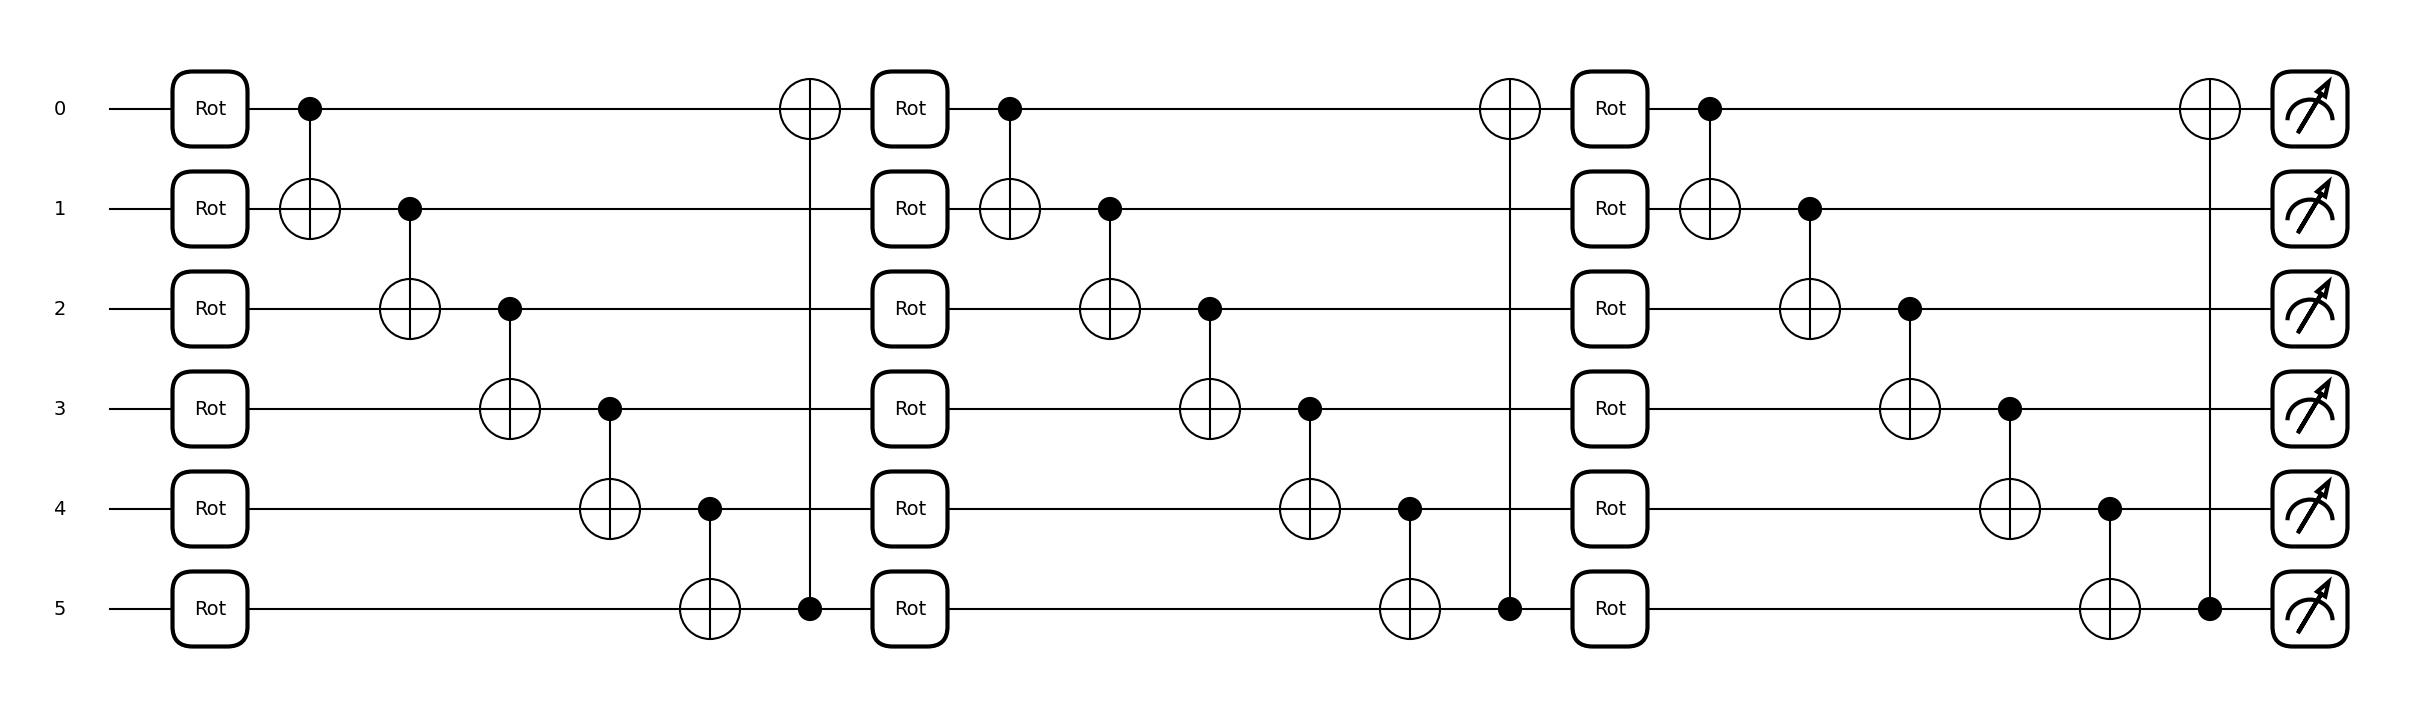

Step: 0 Loss: 0.0453 KL-div: 1.0567
Step: 10 Loss: 0.0044 KL-div: 0.5256
Step: 20 Loss: 0.0026 KL-div: 0.2472
Step: 30 Loss: 0.0016 KL-div: 0.1749
Step: 40 Loss: 0.0009 KL-div: 0.0790
Step: 50 Loss: 0.0006 KL-div: 0.0494
Step: 60 Loss: 0.0004 KL-div: 0.0360
Step: 70 Loss: 0.0003 KL-div: 0.0226
Step: 80 Loss: 0.0002 KL-div: 0.0166
Step: 90 Loss: 0.0002 KL-div: 0.0129
Step: 100 Loss: 0.0001 KL-div: 0.0108
Step: 110 Loss: 0.0001 KL-div: 0.0092
Step: 120 Loss: 0.0001 KL-div: 0.0082
Step: 130 Loss: 0.0001 KL-div: 0.0076
Step: 140 Loss: 0.0001 KL-div: 0.0071
Step: 150 Loss: 0.0001 KL-div: 0.0067
Step: 160 Loss: 0.0001 KL-div: 0.0065
Step: 170 Loss: 0.0001 KL-div: 0.0063
Step: 180 Loss: 0.0001 KL-div: 0.0061
Step: 190 Loss: 0.0001 KL-div: 0.0060


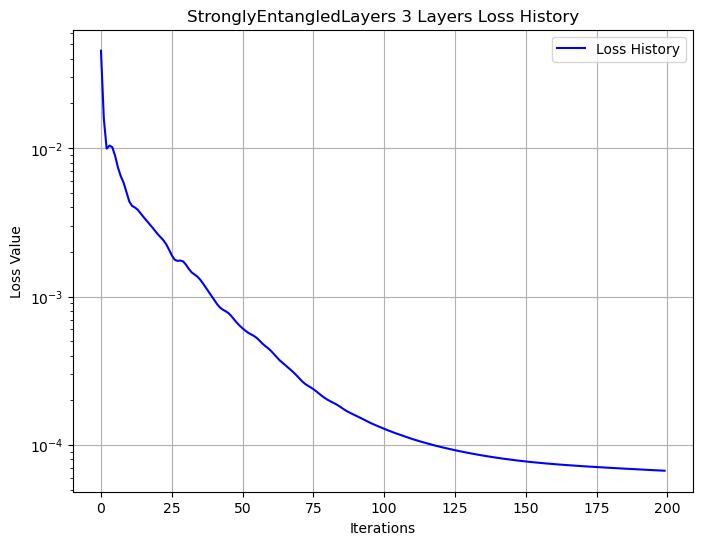

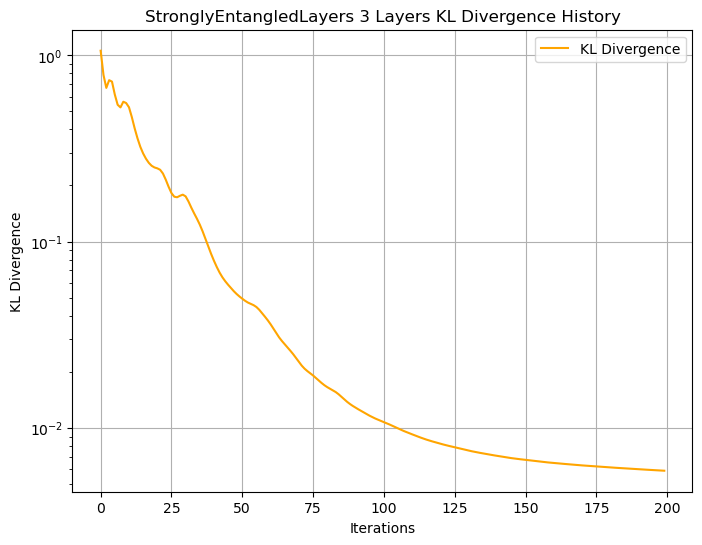

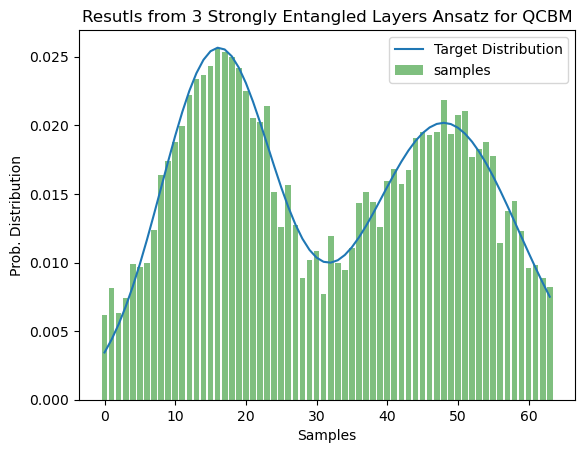

-- 4 Strongly Entangled Layers --


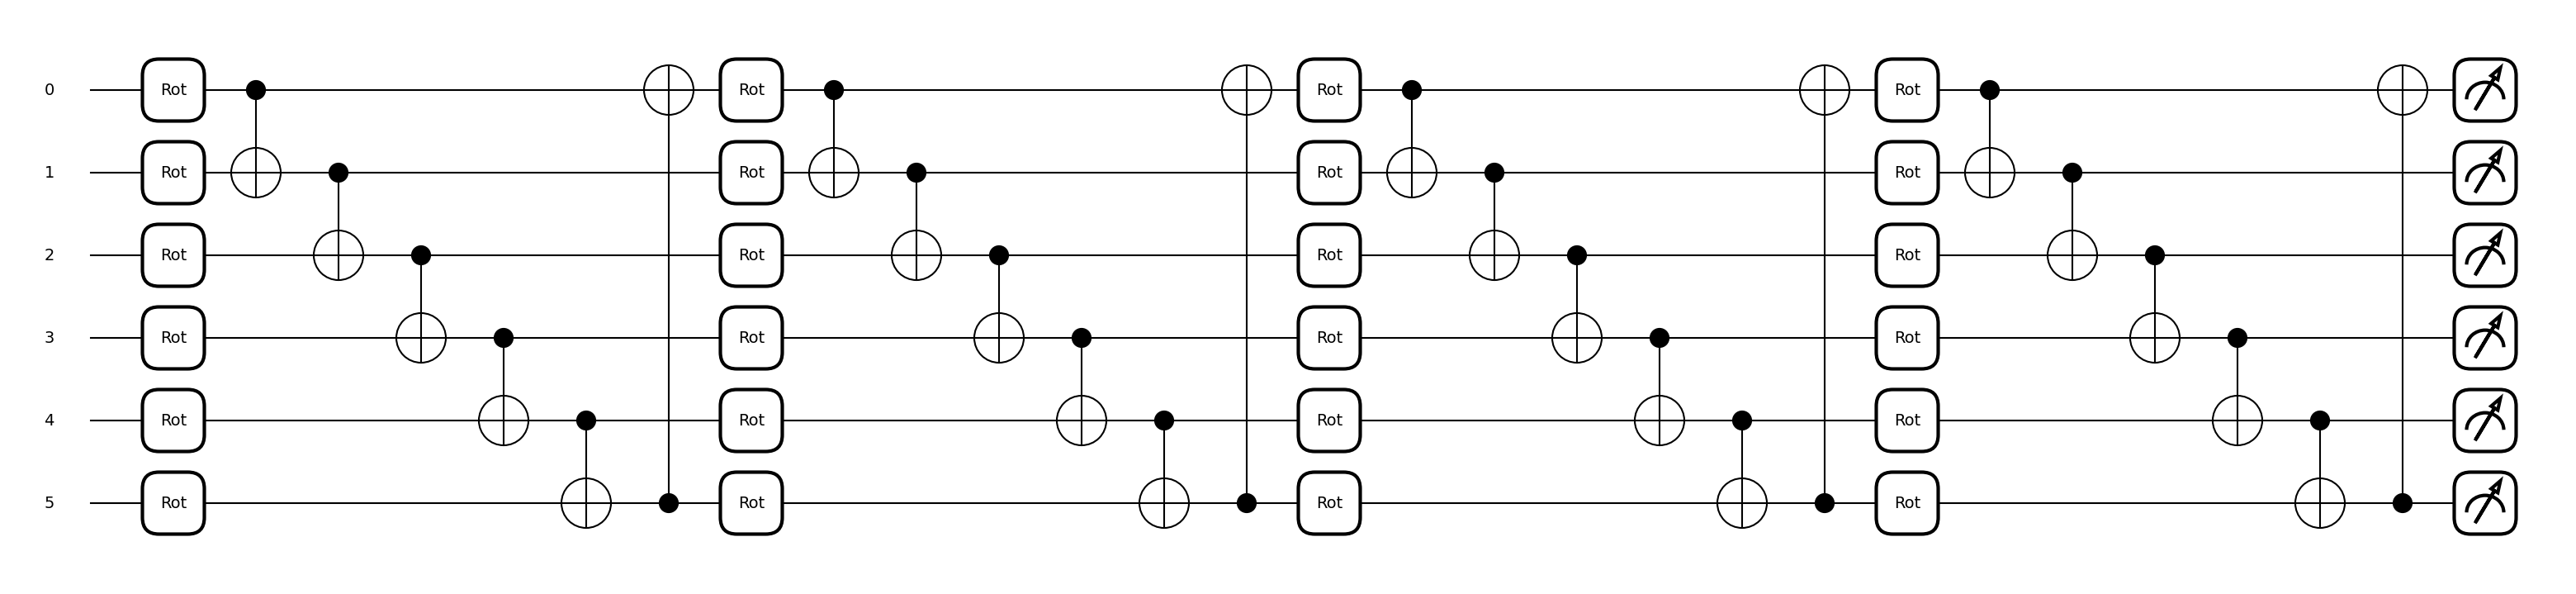

Step: 0 Loss: 0.0160 KL-div: 0.9392
Step: 10 Loss: 0.0027 KL-div: 0.3206
Step: 20 Loss: 0.0012 KL-div: 0.0976
Step: 30 Loss: 0.0006 KL-div: 0.0762
Step: 40 Loss: 0.0005 KL-div: 0.0481
Step: 50 Loss: 0.0003 KL-div: 0.0305
Step: 60 Loss: 0.0003 KL-div: 0.0223
Step: 70 Loss: 0.0002 KL-div: 0.0172
Step: 80 Loss: 0.0002 KL-div: 0.0144
Step: 90 Loss: 0.0001 KL-div: 0.0128
Step: 100 Loss: 0.0001 KL-div: 0.0127
Step: 110 Loss: 0.0001 KL-div: 0.0124
Step: 120 Loss: 0.0001 KL-div: 0.0119
Step: 130 Loss: 0.0001 KL-div: 0.0116
Step: 140 Loss: 0.0001 KL-div: 0.0115
Step: 150 Loss: 0.0001 KL-div: 0.0117
Step: 160 Loss: 0.0001 KL-div: 0.0119
Step: 170 Loss: 0.0001 KL-div: 0.0117
Step: 180 Loss: 0.0001 KL-div: 0.0103
Step: 190 Loss: 0.0001 KL-div: 0.0079


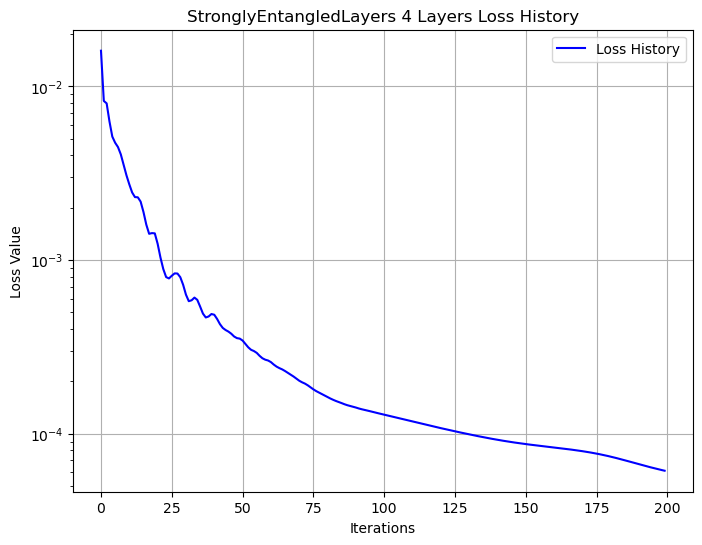

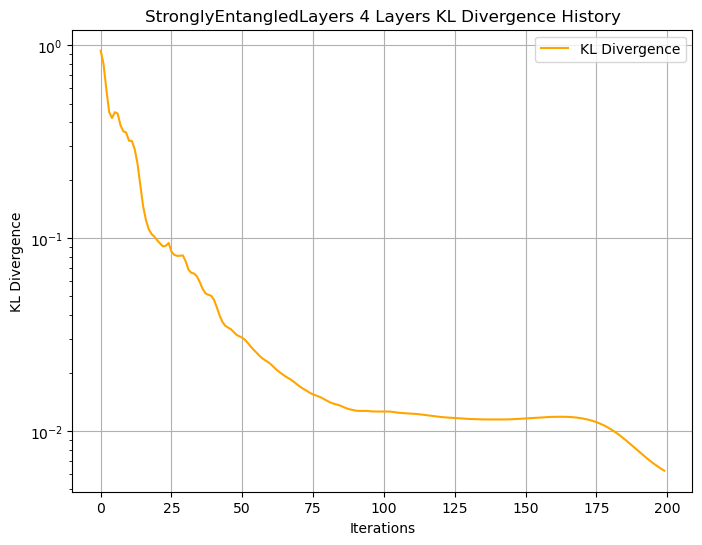

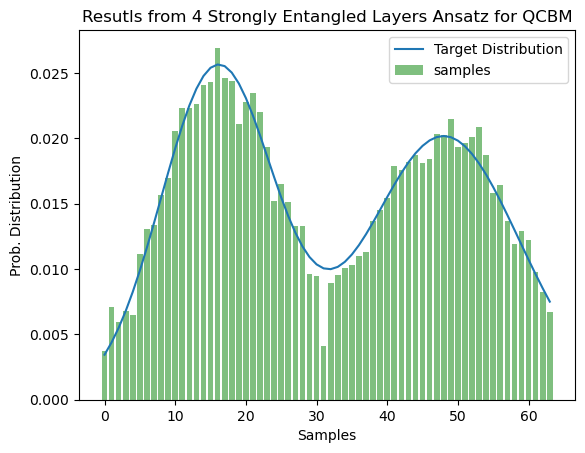

-- 5 Strongly Entangled Layers --


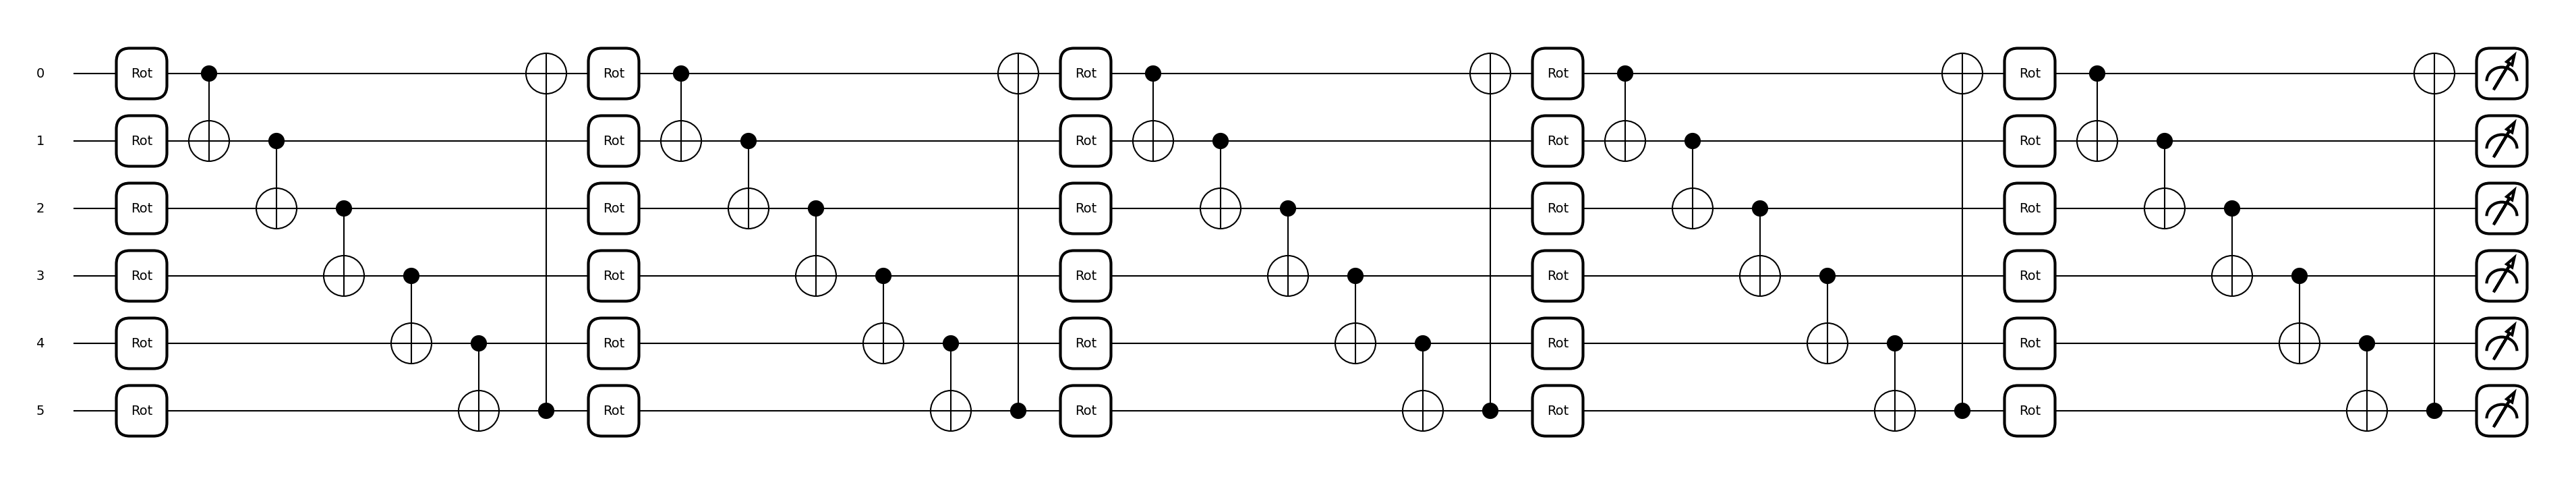

Step: 0 Loss: 0.0105 KL-div: 0.5373
Step: 10 Loss: 0.0018 KL-div: 0.1684
Step: 20 Loss: 0.0007 KL-div: 0.0651
Step: 30 Loss: 0.0003 KL-div: 0.0482
Step: 40 Loss: 0.0002 KL-div: 0.0153
Step: 50 Loss: 0.0001 KL-div: 0.0075
Step: 60 Loss: 0.0000 KL-div: 0.0046
Step: 70 Loss: 0.0000 KL-div: 0.0017
Step: 80 Loss: 0.0000 KL-div: 0.0006
Step: 90 Loss: 0.0000 KL-div: 0.0003
Step: 100 Loss: 0.0000 KL-div: 0.0002
Step: 110 Loss: 0.0000 KL-div: 0.0001
Step: 120 Loss: 0.0000 KL-div: 0.0001
Step: 130 Loss: 0.0000 KL-div: 0.0001
Step: 140 Loss: 0.0000 KL-div: 0.0000
Step: 150 Loss: 0.0000 KL-div: 0.0000
Step: 160 Loss: 0.0000 KL-div: 0.0000
Step: 170 Loss: 0.0000 KL-div: 0.0000
Step: 180 Loss: 0.0000 KL-div: 0.0000
Step: 190 Loss: 0.0000 KL-div: 0.0000


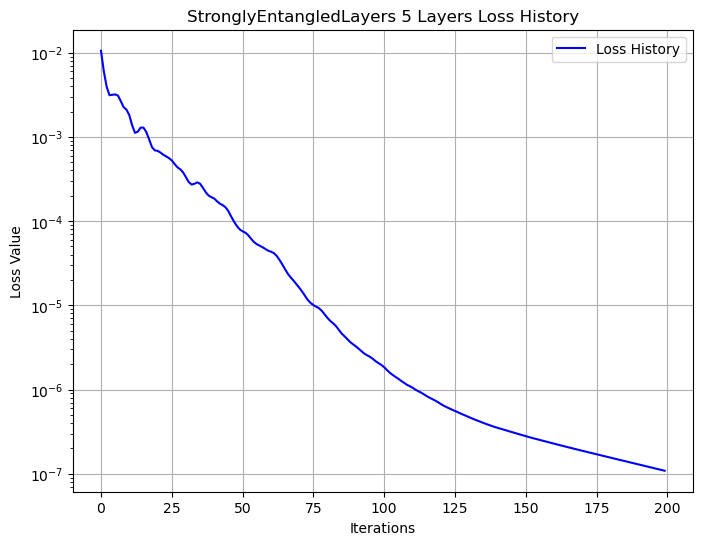

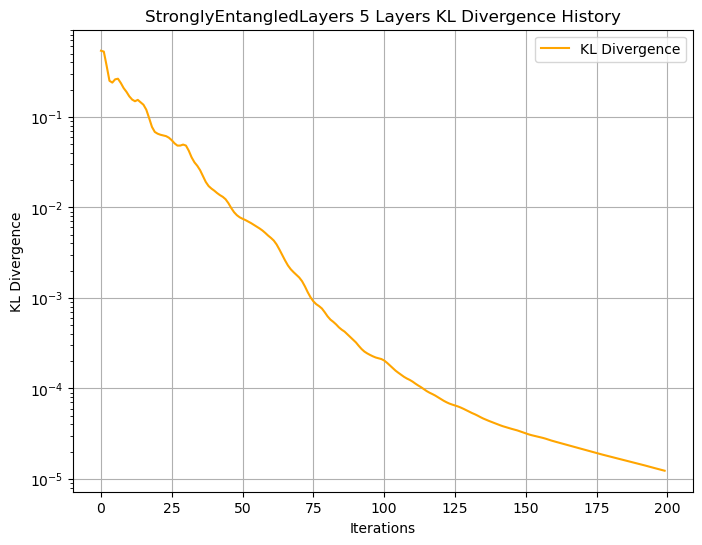

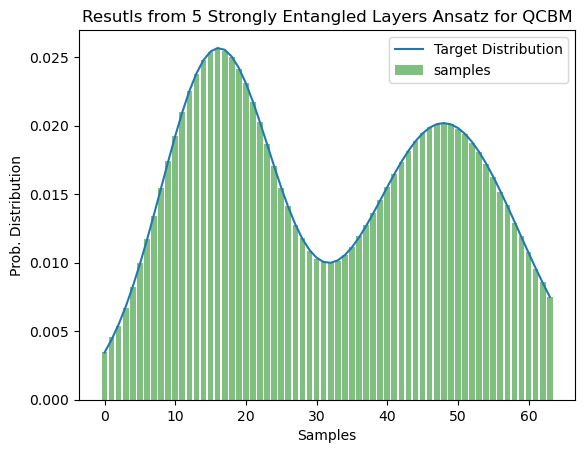

-- 6 Strongly Entangled Layers --


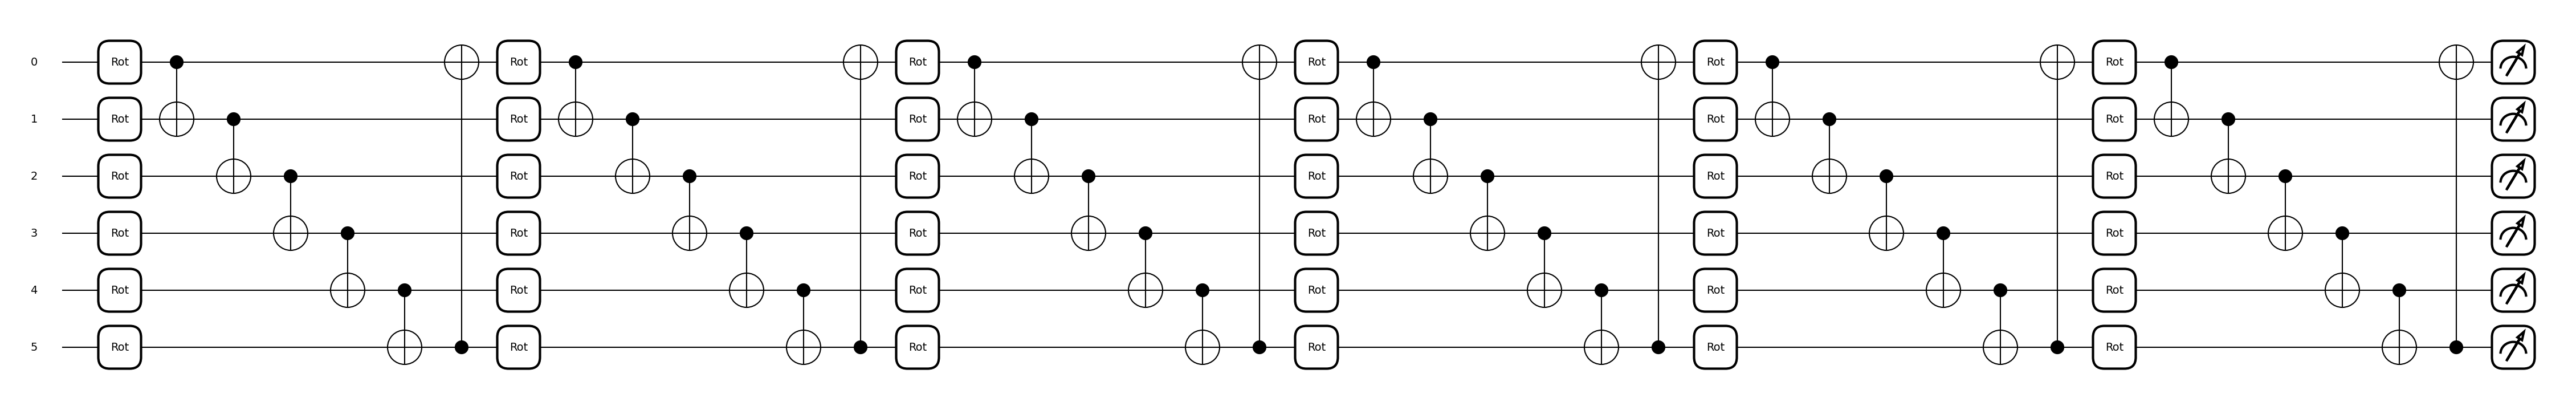

Step: 0 Loss: 0.0144 KL-div: 0.8825
Step: 10 Loss: 0.0011 KL-div: 0.1072
Step: 20 Loss: 0.0006 KL-div: 0.0528
Step: 30 Loss: 0.0002 KL-div: 0.0176
Step: 40 Loss: 0.0001 KL-div: 0.0126
Step: 50 Loss: 0.0001 KL-div: 0.0061
Step: 60 Loss: 0.0000 KL-div: 0.0031
Step: 70 Loss: 0.0000 KL-div: 0.0017
Step: 80 Loss: 0.0000 KL-div: 0.0010
Step: 90 Loss: 0.0000 KL-div: 0.0005
Step: 100 Loss: 0.0000 KL-div: 0.0002
Step: 110 Loss: 0.0000 KL-div: 0.0001
Step: 120 Loss: 0.0000 KL-div: 0.0000
Step: 130 Loss: 0.0000 KL-div: 0.0000
Step: 140 Loss: 0.0000 KL-div: 0.0000
Step: 150 Loss: 0.0000 KL-div: 0.0000
Step: 160 Loss: 0.0000 KL-div: 0.0000
Step: 170 Loss: 0.0000 KL-div: 0.0000
Step: 180 Loss: 0.0000 KL-div: 0.0000
Step: 190 Loss: 0.0000 KL-div: 0.0000


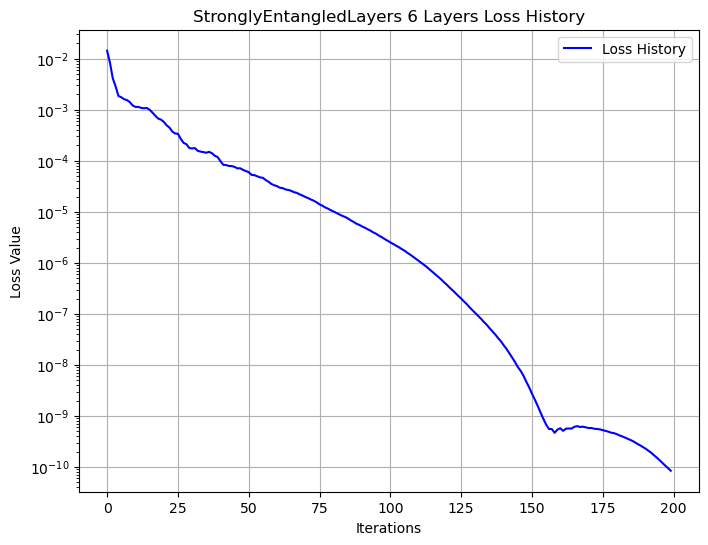

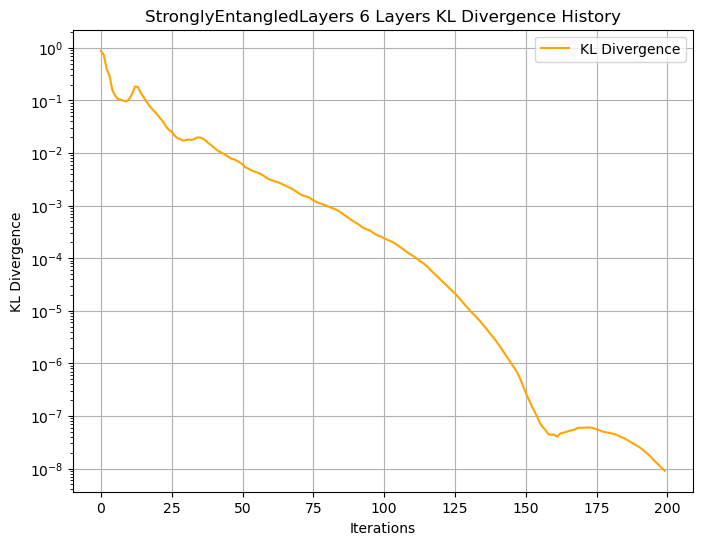

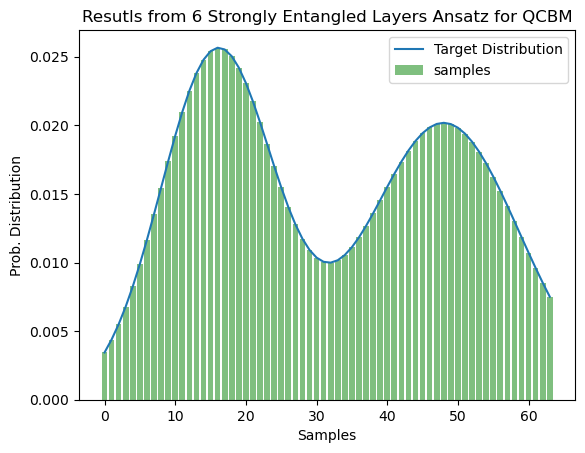

-- 7 Strongly Entangled Layers --


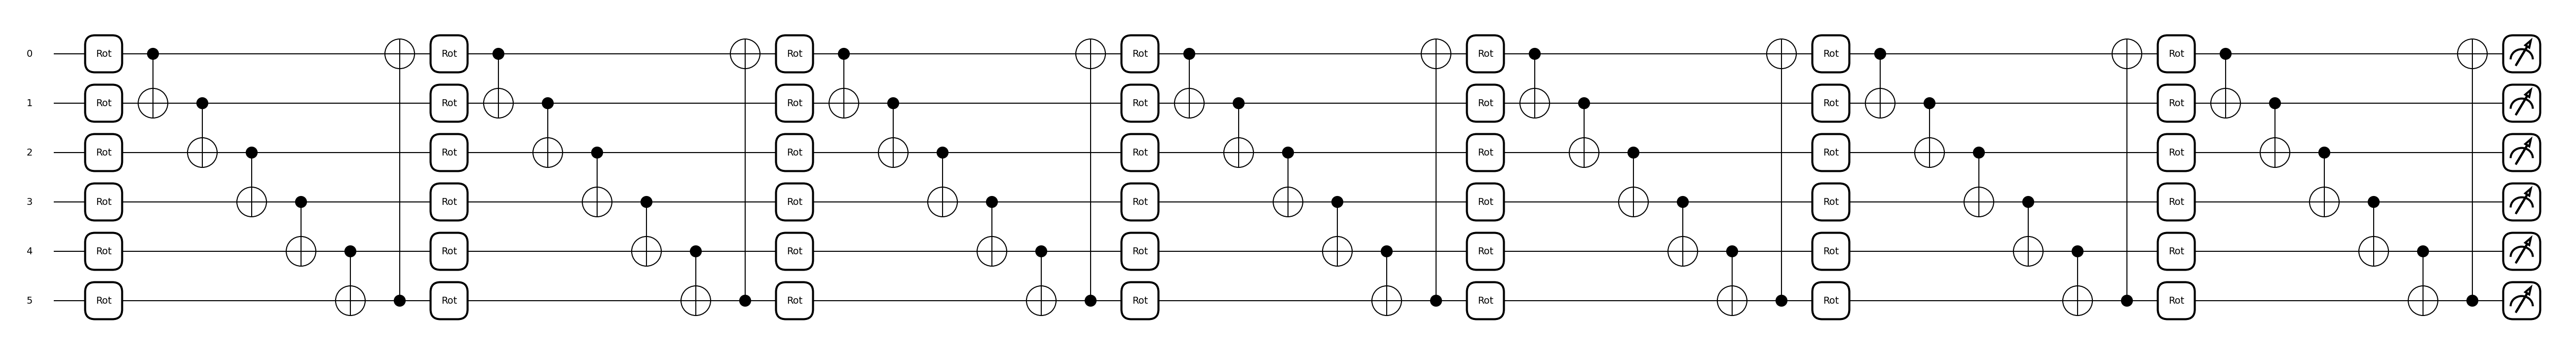

Step: 0 Loss: 0.0189 KL-div: 0.7130
Step: 10 Loss: 0.0029 KL-div: 0.2732
Step: 20 Loss: 0.0009 KL-div: 0.0763
Step: 30 Loss: 0.0004 KL-div: 0.0370
Step: 40 Loss: 0.0001 KL-div: 0.0164
Step: 50 Loss: 0.0001 KL-div: 0.0060
Step: 60 Loss: 0.0000 KL-div: 0.0018
Step: 70 Loss: 0.0000 KL-div: 0.0008
Step: 80 Loss: 0.0000 KL-div: 0.0002
Step: 90 Loss: 0.0000 KL-div: 0.0001
Step: 100 Loss: 0.0000 KL-div: 0.0000
Step: 110 Loss: 0.0000 KL-div: 0.0000
Step: 120 Loss: 0.0000 KL-div: 0.0000
Step: 130 Loss: 0.0000 KL-div: 0.0000
Step: 140 Loss: 0.0000 KL-div: 0.0000
Step: 150 Loss: 0.0000 KL-div: 0.0000
Step: 160 Loss: 0.0000 KL-div: 0.0000
Step: 170 Loss: 0.0000 KL-div: 0.0000
Step: 180 Loss: 0.0000 KL-div: 0.0000
Step: 190 Loss: 0.0000 KL-div: 0.0000


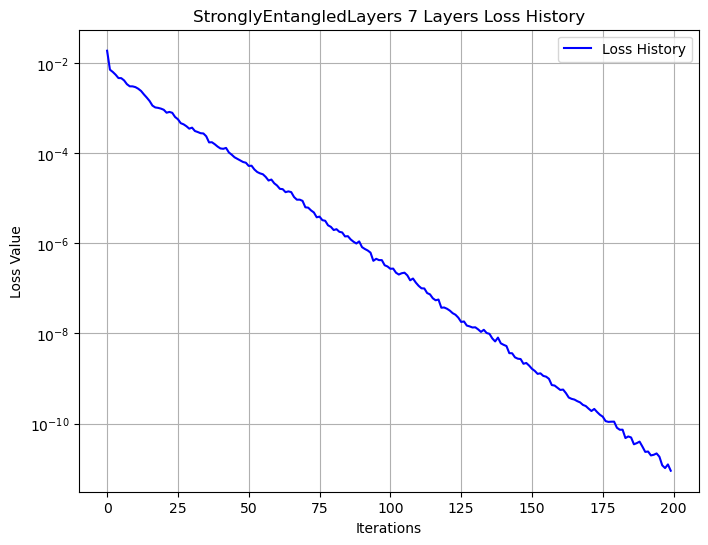

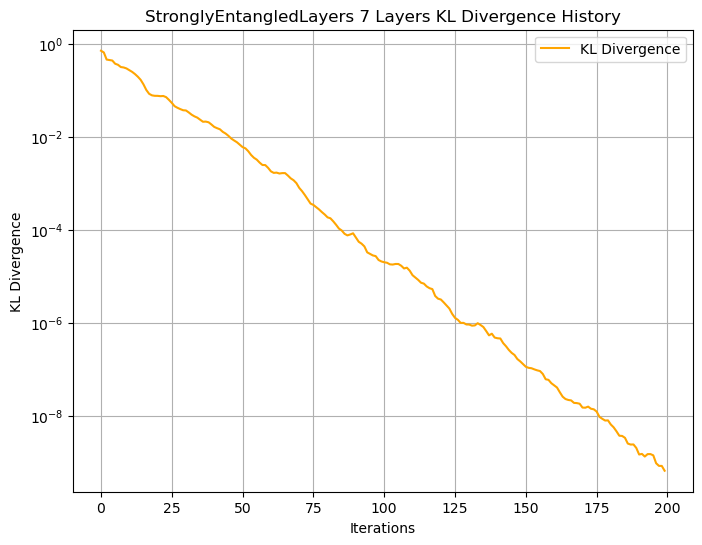

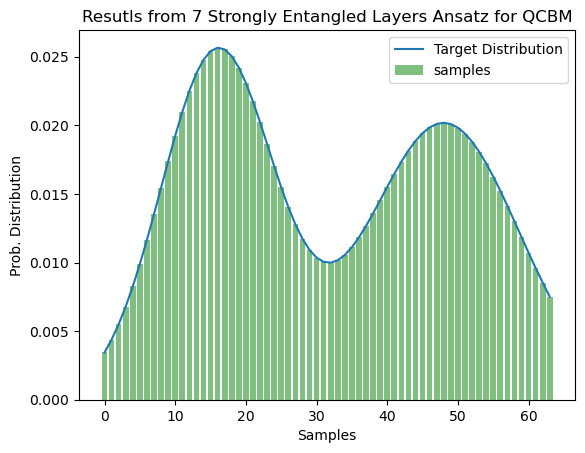

-- 8 Strongly Entangled Layers --


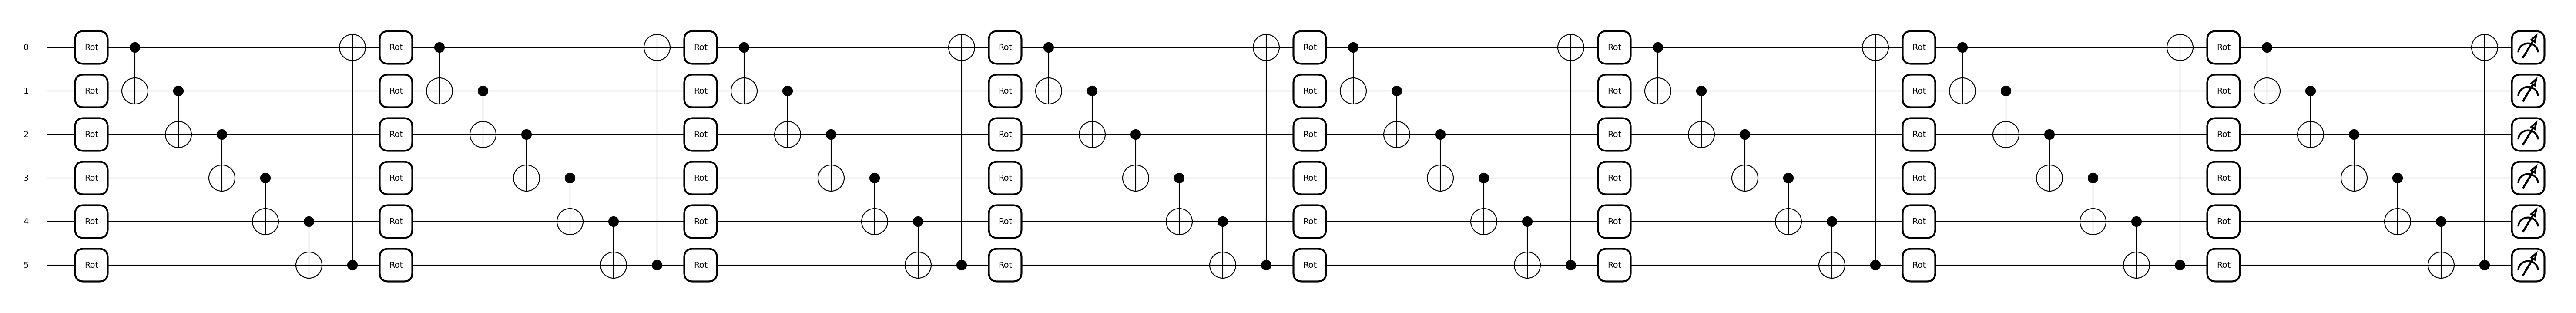

Step: 0 Loss: 0.0197 KL-div: 0.9436
Step: 10 Loss: 0.0026 KL-div: 0.1866
Step: 20 Loss: 0.0007 KL-div: 0.0574
Step: 30 Loss: 0.0003 KL-div: 0.0240
Step: 40 Loss: 0.0001 KL-div: 0.0071
Step: 50 Loss: 0.0000 KL-div: 0.0030
Step: 60 Loss: 0.0000 KL-div: 0.0015
Step: 70 Loss: 0.0000 KL-div: 0.0004
Step: 80 Loss: 0.0000 KL-div: 0.0001
Step: 90 Loss: 0.0000 KL-div: 0.0001
Step: 100 Loss: 0.0000 KL-div: 0.0000
Step: 110 Loss: 0.0000 KL-div: 0.0000
Step: 120 Loss: 0.0000 KL-div: 0.0000
Step: 130 Loss: 0.0000 KL-div: 0.0000
Step: 140 Loss: 0.0000 KL-div: 0.0000
Step: 150 Loss: 0.0000 KL-div: 0.0000
Step: 160 Loss: 0.0000 KL-div: 0.0000
Step: 170 Loss: 0.0000 KL-div: 0.0000
Step: 180 Loss: 0.0000 KL-div: 0.0000
Step: 190 Loss: 0.0000 KL-div: 0.0000


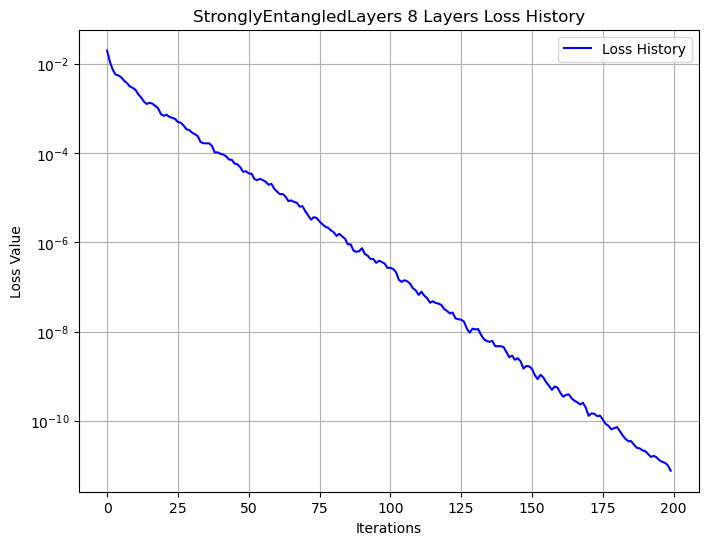

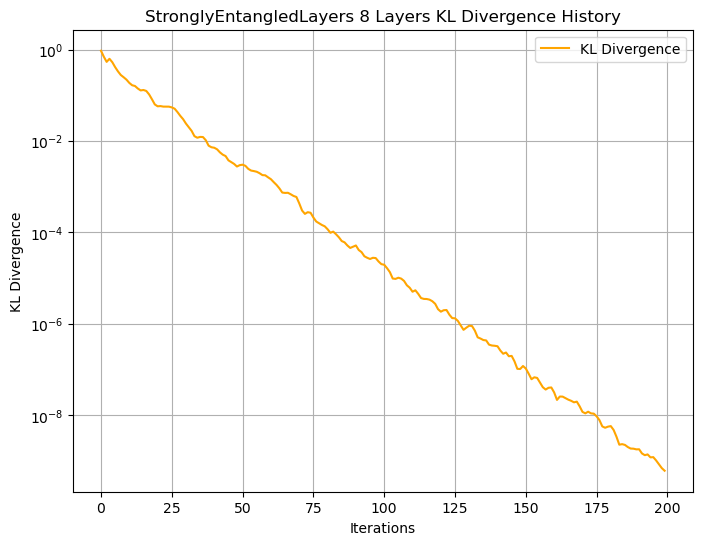

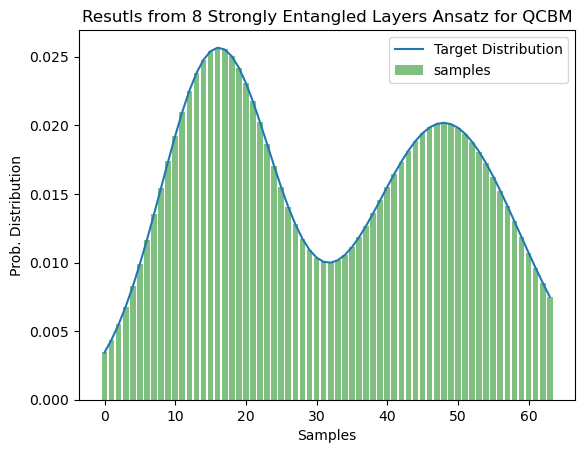

-- 9 Strongly Entangled Layers --


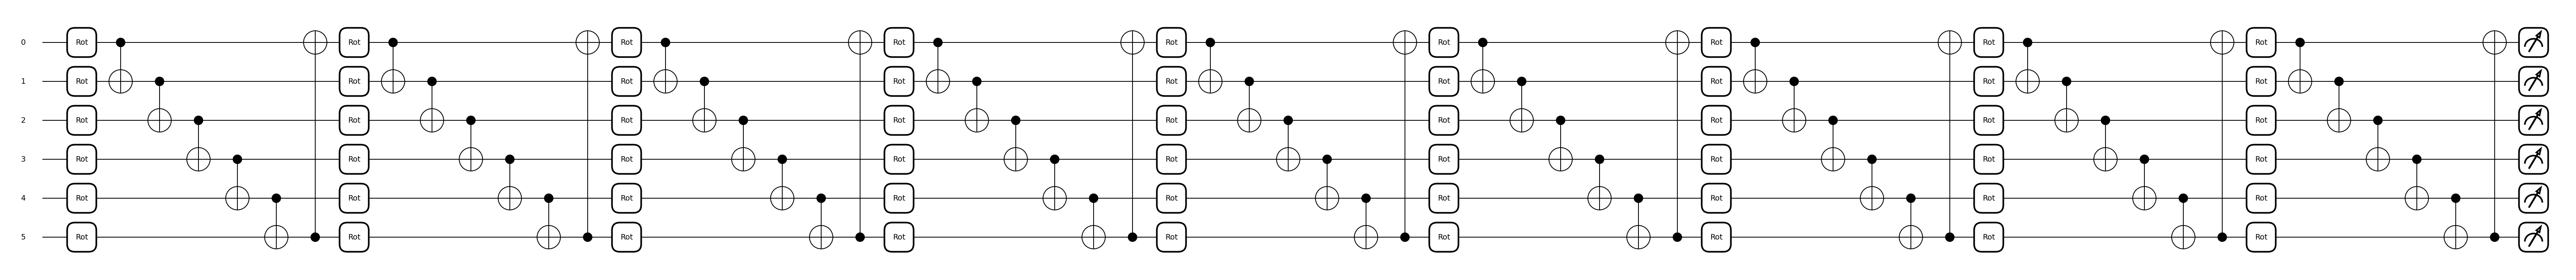

Step: 0 Loss: 0.0101 KL-div: 0.6949
Step: 10 Loss: 0.0016 KL-div: 0.1786
Step: 20 Loss: 0.0009 KL-div: 0.1278
Step: 30 Loss: 0.0003 KL-div: 0.0286
Step: 40 Loss: 0.0001 KL-div: 0.0079
Step: 50 Loss: 0.0000 KL-div: 0.0030
Step: 60 Loss: 0.0000 KL-div: 0.0007
Step: 70 Loss: 0.0000 KL-div: 0.0004
Step: 80 Loss: 0.0000 KL-div: 0.0001
Step: 90 Loss: 0.0000 KL-div: 0.0001
Step: 100 Loss: 0.0000 KL-div: 0.0000
Step: 110 Loss: 0.0000 KL-div: 0.0000
Step: 120 Loss: 0.0000 KL-div: 0.0000
Step: 130 Loss: 0.0000 KL-div: 0.0000
Step: 140 Loss: 0.0000 KL-div: 0.0000
Step: 150 Loss: 0.0000 KL-div: 0.0000
Step: 160 Loss: 0.0000 KL-div: 0.0000
Step: 170 Loss: 0.0000 KL-div: 0.0000
Step: 180 Loss: 0.0000 KL-div: 0.0000
Step: 190 Loss: 0.0000 KL-div: 0.0000


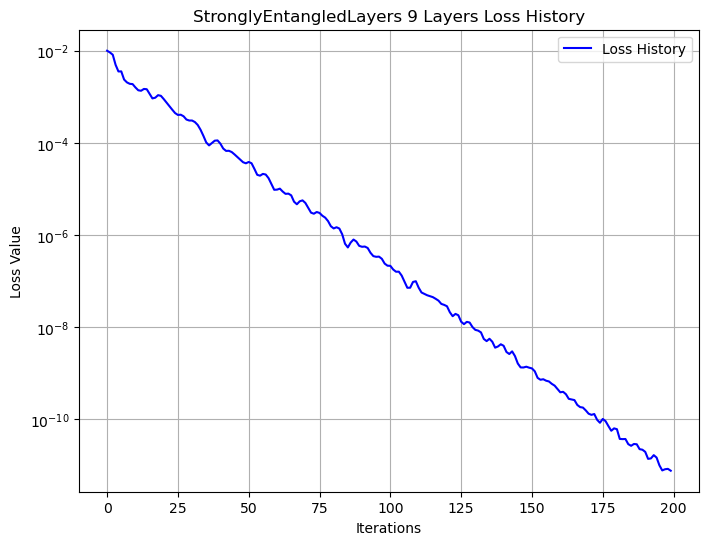

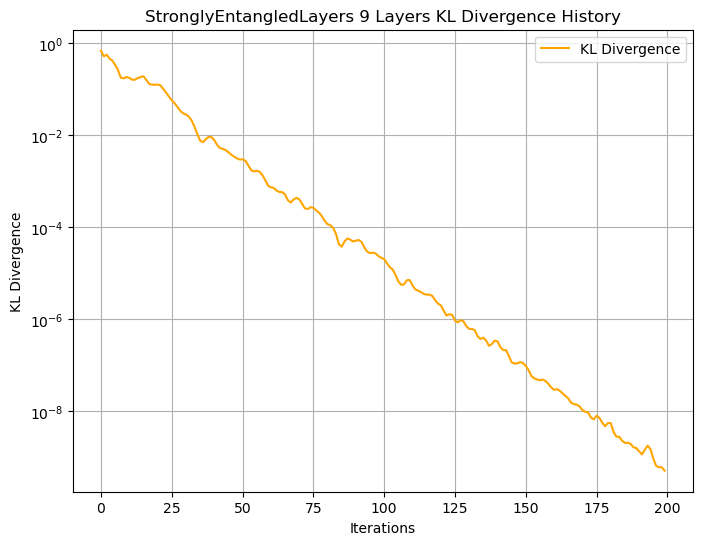

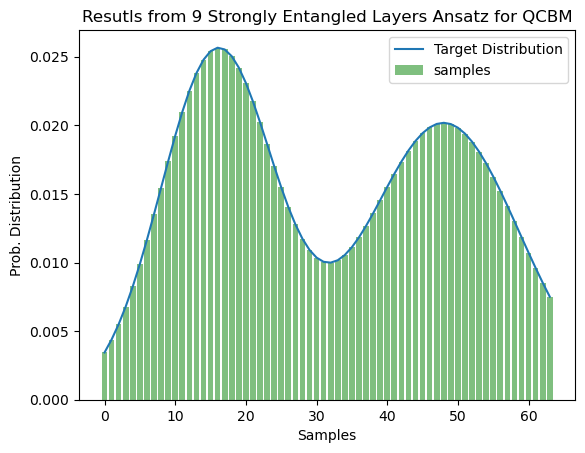

-- 10 Strongly Entangled Layers --


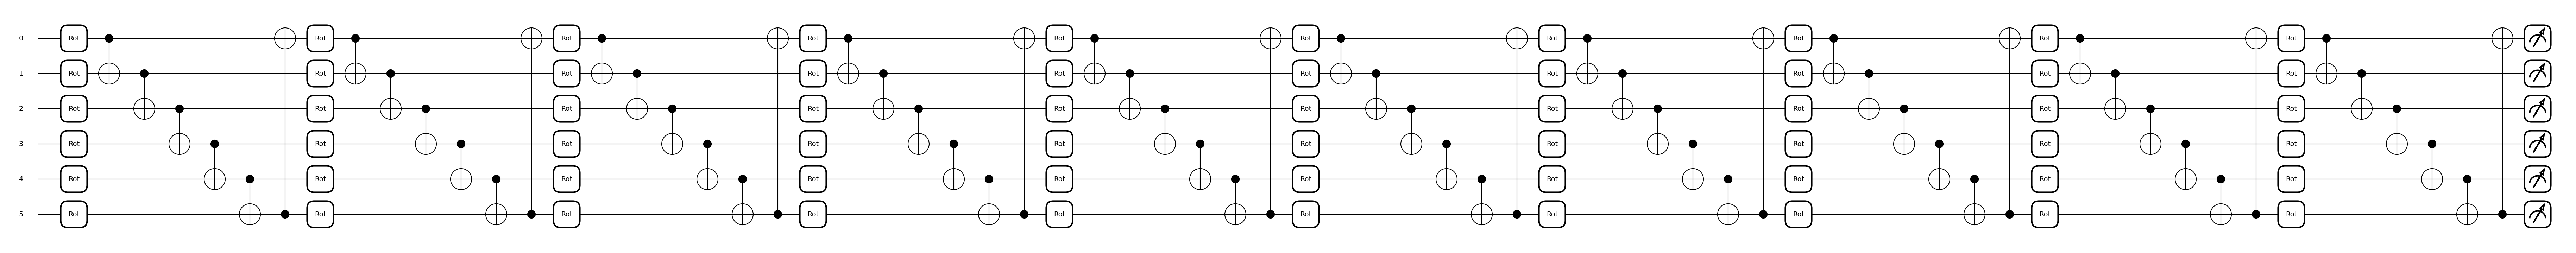

Step: 0 Loss: 0.0090 KL-div: 0.6841
Step: 10 Loss: 0.0019 KL-div: 0.1402
Step: 20 Loss: 0.0004 KL-div: 0.0449
Step: 30 Loss: 0.0002 KL-div: 0.0212
Step: 40 Loss: 0.0001 KL-div: 0.0071
Step: 50 Loss: 0.0000 KL-div: 0.0018
Step: 60 Loss: 0.0000 KL-div: 0.0007
Step: 70 Loss: 0.0000 KL-div: 0.0003
Step: 80 Loss: 0.0000 KL-div: 0.0001
Step: 90 Loss: 0.0000 KL-div: 0.0000
Step: 100 Loss: 0.0000 KL-div: 0.0000
Step: 110 Loss: 0.0000 KL-div: 0.0000
Step: 120 Loss: 0.0000 KL-div: 0.0000
Step: 130 Loss: 0.0000 KL-div: 0.0000
Step: 140 Loss: 0.0000 KL-div: 0.0000
Step: 150 Loss: 0.0000 KL-div: 0.0000
Step: 160 Loss: 0.0000 KL-div: 0.0000
Step: 170 Loss: 0.0000 KL-div: 0.0000
Step: 180 Loss: 0.0000 KL-div: 0.0000
Step: 190 Loss: 0.0000 KL-div: 0.0000


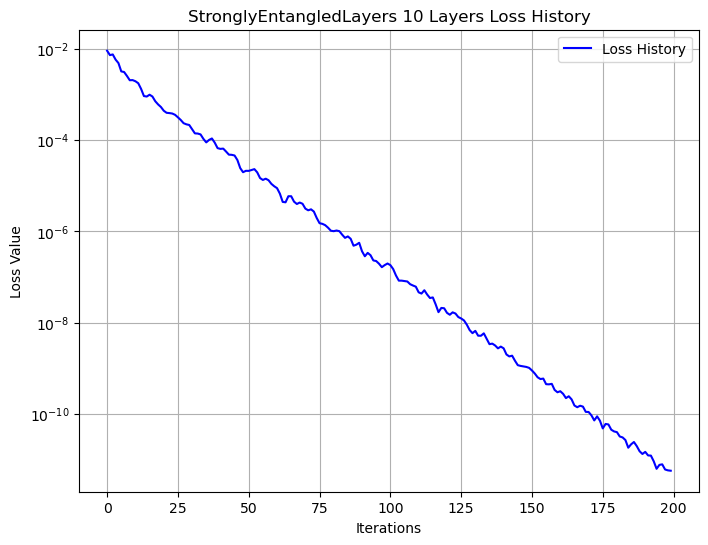

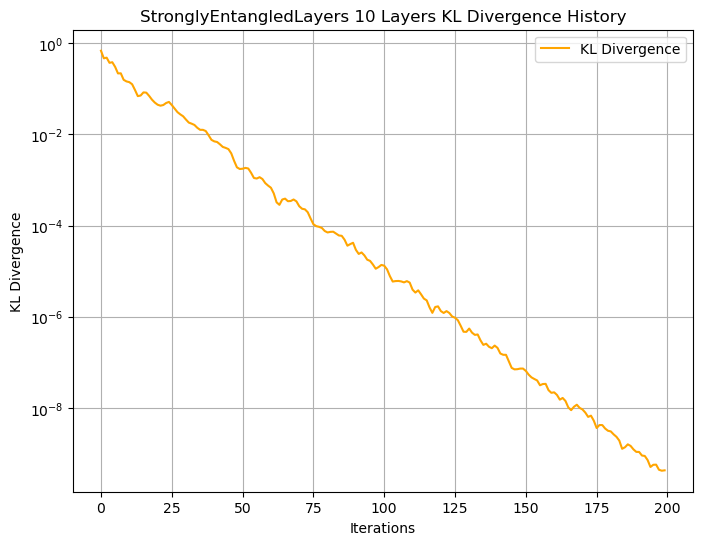

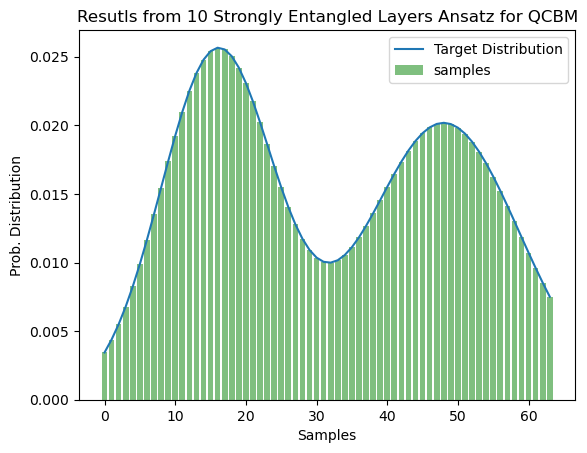

In [22]:
nLayers_test = [1,2,3,4,5,6,7,8,9,10]
hist_layers = []
divs_layers = []

for test in nLayers_test:
    history, divs = QCBM_N_layers_run(n_layers = test)
    hist_layers.append(history)
    divs_layers.append(divs)

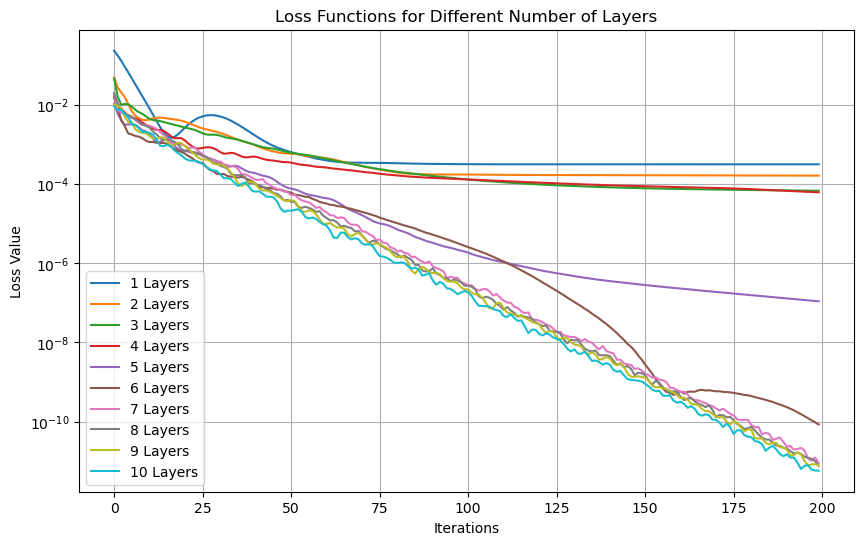

In [25]:
# Plot all loss histories from hist_layers
plt.figure(figsize=(10, 6))
for i, history in enumerate(hist_layers):
    plt.plot(range(len(history)), history, label=f"{nLayers_test[i]} Layers")

# Set logarithmic scale for y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Functions for Different Number of Layers")
plt.legend()
plt.savefig('Analysis/LossFunctionsDifferentNumberofLayers')
plt.grid(True)
plt.show()

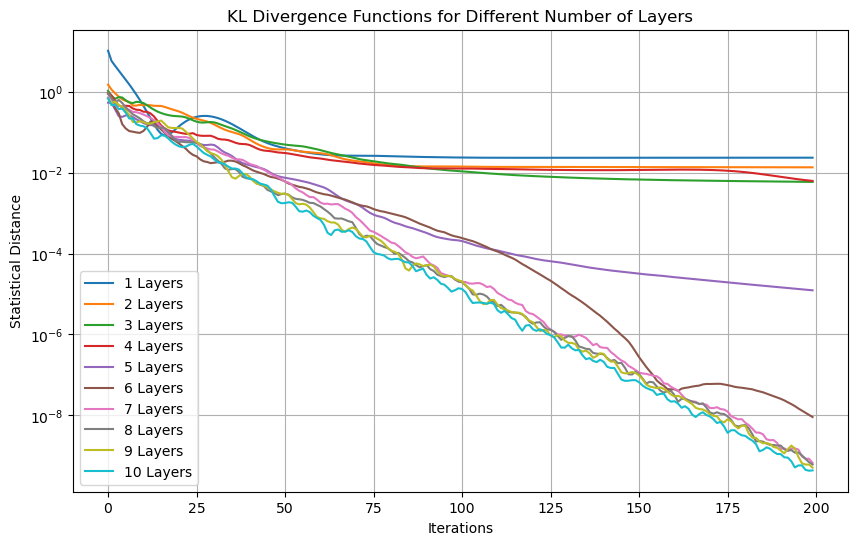

In [26]:
# Plot all loss histories from hist_layers
plt.figure(figsize=(10, 6))
for i, divs in enumerate(divs_layers):
    plt.plot(range(len(divs)), divs, label=f"{nLayers_test[i]} Layers")

# Set logarithmic scale for y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Statistical Distance")
plt.title("KL Divergence Functions for Different Number of Layers")
plt.savefig('Analysis/KL_Div_DifferentNumberofLayers')
plt.legend()
plt.grid(True)
plt.show()